# Emotion Detection Training
This project is inspired from https://github.com/dhruvpandey662/Emotion-detection

We will be training using sigmoid activation function.

Data source: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

Note: Unzip the file `data.zip` and move both folders `train` and `test` to the root directory

## Import Statement

In [ ]:
# If you do not have those libraries:
!pip install tensorflow
!pip install keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from tensorflow.keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.losses import categorical_crossentropy

## Build the model
We will be using MobileNet as it good base to start with. MobileNet has 28 layers of CNN and non-CNN layers

In [52]:
# Working with pre trained model
# Here, we use MobileNet, which has 28 layers of CNN and Non-CNN layers. We then reomve the top layer and added the flatten and dense to fit our use case

#The input_shape parameter is set to (224, 224, 3), which represents the expected input image shape with height, width, and 3 color channels (RGB).
#The include_top parameter is set to False, which means the last fully connected layer (top) of the MobileNet model will not be included.
base_model = MobileNet( input_shape=(224,224,3), include_top= False )

#By setting trainable to False, we are essentially freezing the weights of the pre-trained model's layers, which means they will not be updated during training.
for layer in base_model.layers:
  layer.trainable = False

# Set the output tensor to a 1 dimensional vector
x = Flatten()(base_model.output)
# Adds dense layer of 7 units. Softmax for common classifications problems
x = Dense(units=7 , activation='softplus' )(x)

# creating our model.
model = Model(base_model.input, x)

In [53]:
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

## Preparing Data Using Data Generator

In [54]:
### Trainign Data
# creating an object as an instance of "ImageDatagenerator"
train_datagen = ImageDataGenerator(
     zoom_range = 0.2,
     shear_range = 0.2,
     horizontal_flip=True,
     rescale = 1./255
)

# set the image to 224 x 224 and train by batch of 32
train_data = train_datagen.flow_from_directory(directory= "./train",
                                               target_size=(224,224),
                                               batch_size=32,
                                  )


train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

In [55]:
### Test data
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "./test",
                                           target_size=(224,224),
                                           batch_size=32,
                                  )

Found 7178 images belonging to 7 classes.


## Early stopping and model checkpoint
This is to prevent the model from being overtrain

In [56]:
## having early stopping and model check point
# We will save the weights of the epoch on the modelCheckpoint and use the min delta to stop at the optimal epochs to prevent overtraining
from keras.callbacks import ModelCheckpoint, EarlyStopping


# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')
# model check point
mc = ModelCheckpoint(filepath="sigmoid4.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list
call_back = [es, mc]


In [57]:
hist = model.fit(train_data,
                           steps_per_epoch= 60,
                           epochs= 30,
                           validation_data= val_data,
                           validation_steps= 8,
                           callbacks=[es,mc])

Epoch 1/40
60/60 [==============================] - ETA: 0s - loss: 5.3766 - accuracy: 0.2234
Epoch 1: val_accuracy improved from -inf to 0.28125, saving model to softplus4.h5
60/60 [==============================] - 45s 721ms/step - loss: 5.3766 - accuracy: 0.2234 - val_loss: 5.4998 - val_accuracy: 0.2812
Epoch 2/40
60/60 [==============================] - ETA: 0s - loss: 5.0955 - accuracy: 0.2773
Epoch 2: val_accuracy did not improve from 0.28125
60/60 [==============================] - 43s 714ms/step - loss: 5.0955 - accuracy: 0.2773 - val_loss: 5.6437 - val_accuracy: 0.2500
Epoch 3/40
60/60 [==============================] - ETA: 0s - loss: 5.0949 - accuracy: 0.2411
Epoch 3: val_accuracy did not improve from 0.28125
60/60 [==============================] - 44s 727ms/step - loss: 5.0949 - accuracy: 0.2411 - val_loss: 5.9782 - val_accuracy: 0.2773
Epoch 4/40
60/60 [==============================] - ETA: 0s - loss: 5.2018 - accuracy: 0.2990
Epoch 4: val_accuracy improved from 0.28125 

In [58]:
# Loading the best fit model
from keras.models import load_model
model = load_model("./sigmoid4.h5")

In [59]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

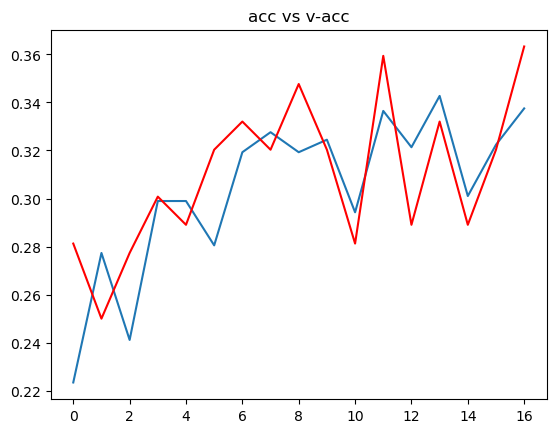

In [60]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

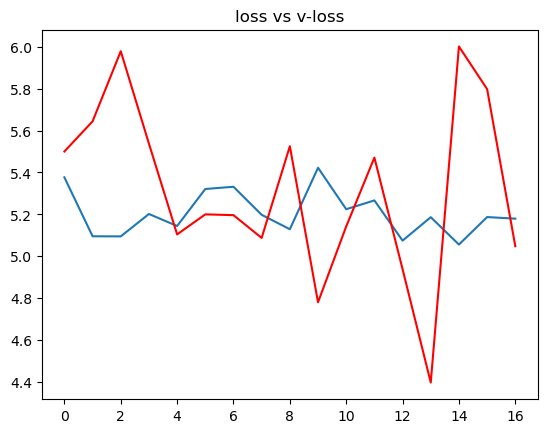

In [61]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [62]:
# just to map o/p values
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

1/1 [==============================] - 0s 39ms/step
 the image is of neutral


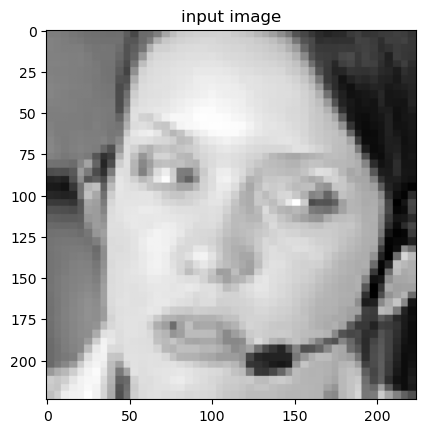

In [64]:
# path for the image to see if it predics correct class

path = "./test/angry/im2.png"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()